# Janine Par: DSC630 - Week10 Recommendation System


### Load Libraries Needed

In [28]:
#Install library for Fuzzy matching
#pip install thefuzz

In [29]:
import numpy as np  
import pandas as pd  
import numbers
import matplotlib.pyplot as plt
import warnings
import scipy.stats as ss
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

### Step 1: Load the Small Movie Lense to Panda Dataframe

In [40]:
df_links = pd.read_csv(f'ml-latest-small/links.csv')
df_movies = pd.read_csv(f'ml-latest-small/movies.csv')
df_ratings = pd.read_csv(f'ml-latest-small/ratings.csv')
df_tags = pd.read_csv(f'ml-latest-small/tags.csv')

#### Step 2: Display and view details of each datasets

In [31]:
def print_df(df, name):
    '''Display df shape and first row '''
    print(f'{name} data has {df.shape[0]} rows and {df.shape[1]} columns. \n')
    display(df.head(5))
    
print_df(df_links, 'links')
print_df(df_movies, 'movies')
print_df(df_ratings, 'ratings')
print_df(df_tags, 'tags')

links data has 9742 rows and 3 columns. 



,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


movies data has 9742 rows and 3 columns. 



,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


ratings data has 100836 rows and 4 columns. 



,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


tags data has 3683 rows and 4 columns. 



,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


## EDA
#### Step 3: Check Null values

In [32]:
#Check Nulls
def df_missing_cols (df, name):
    for c in df.columns:
            is_missing=df[c].isna().sum()
            if is_missing > 0:
                print ("dataframe {} column {} has {} missing values (s)". format (name,c,is_missing))


In [41]:
df_missing_cols(df_links, 'links')
df_missing_cols(df_movies, 'movies')
df_missing_cols(df_ratings, 'ratings')
df_missing_cols(df_tags, 'tags')

dataframe links column tmdbId has 8 missing values (s)


In [42]:
df_links['tmdbId'] = df_links['tmdbId'].fillna(0)

##### Step 3.2: Merge Movies and ratings datasets

In [74]:
df = pd.merge(df_movies, df_ratings)
df.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483


##### Step 3.4: Remove Timestamp, we will not need this column for user user collaborative filtering

In [75]:
df.drop( "timestamp", inplace = True, axis = 1 ) 

##### Step 3.5 See User, Movie and Rating information 

In [78]:
num_users = len(df['userId'].value_counts())
print('Unique number of users in the dataset: {}'.format(num_users))

Unique number of users in the dataset: 610


In [79]:
num_items = len(df['title'].value_counts())
print('Unique number of movies in the dataset: {}'.format(num_items))


Unique number of movies in the dataset: 9719


In [102]:
df_rating_cnt = pd.DataFrame(df.groupby(['rating']).size(), 
                             columns=['count']).sort_values (by='rating'
                                                             , ascending=True)
df_rating_cnt

,count
rating,
0.5,1370
1.0,2811
1.5,1791
2.0,7551
2.5,5550
3.0,20047
3.5,13136
4.0,26818
4.5,8551


Text(0, 0.5, '# Ratings')

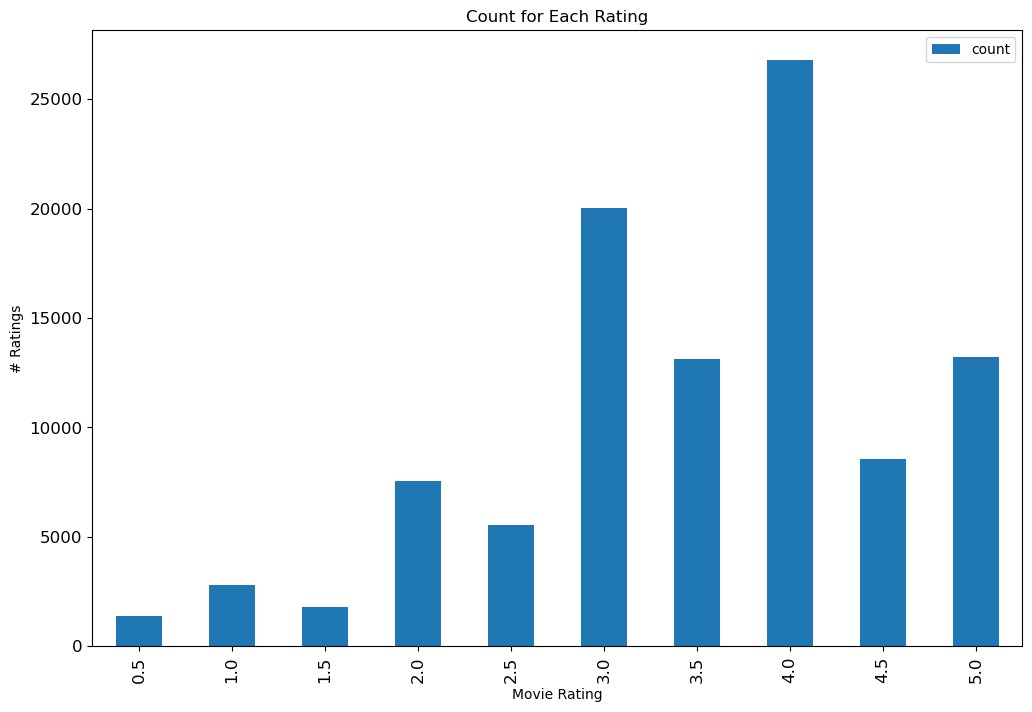

In [112]:
ax = df_rating_cnt.reset_index().rename(columns={'index': 'rating score'}).plot('rating','count', 'bar',
    figsize=(12, 8),
    title='Count for Each Rating',
    fontsize=12)

ax.set_xlabel("Movie Rating")
ax.set_ylabel("# Ratings")

We have observed that this distribution chart shows that ratings 3 and 4 are given in more numbers by the users.

#### Step 5: Build Recommendation System - Collaborative Filtering

The collaborative filtering approach is based on user behavior to generate recommendation System. In this, the system looks for users who share the same rating patterns with the user whom the prediction is for. 

I have referenced and used the method from "Building a MovieLens Recommender System" by Jull Cates with Tutorial.

Building a MovieLens Recommender System. (2023, August 16). [Video]. Youtube. https://www.youtube.com/watch?v=XfAe-HLysOM




##### Step 5.1: Create Sparse Matrix 
Contains four mapper dictionaries:

* user_mapper: maps user id to user index

* movie_mapper: maps movie id to movie index

* user_inv_mapper: maps user index to user id

* movie_inv_mapper: maps movie index to movie id

In [48]:
M = df['userId'].nunique()
N = df['movieId'].nunique()
user_mapper = dict(zip(np.unique(df["userId"]), list(range(M))))  #User ID and User Index
movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(N)))) # Movie ID to Movie Index
user_inv_mapper = dict(zip(list(range(M)), np.unique(df["userId"])))
movie_inv_mapper = dict(zip(list(range(N)), np.unique(df["movieId"])))

In [49]:
user_index = [user_mapper[i] for i in df['userId']]
item_index = [movie_mapper[i] for i in df['movieId']]

Build Sparse Matrix 

In [51]:
from scipy.sparse import csr_matrix
X = csr_matrix((df["rating"], (user_index,item_index)), shape=(M,N))

Read and review the sparse matrix

In [54]:
print(f"Most active user rated {n_ratings_per_user.max()} movies.")
print(f"Least active user rated {n_ratings_per_user.min()} movies.")

Most active user rated 2698 movies.
Least active user rated 20 movies.


In [55]:
n_ratings_per_movie = X.getnnz(axis=0)
len(n_ratings_per_movie)

9724

In [56]:
print(f"Most rated movie has {n_ratings_per_movie.max()} ratings.")
print(f"Least rated movie has {n_ratings_per_movie.min()} ratings.")

Most rated movie has 329 ratings.
Least rated movie has 1 ratings.


##### Step 5.2: Use K-Nearest Neighbors to identify the movies that have the most similar user engagement vectors for the entered movie


In [107]:
from sklearn.neighbors import NearestNeighbors

def find_similar_movies(movie_id, X, movie_mapper,
                        movie_inv_mapper, k, metric='cosine'):
    """
    Finds k-nearest neighbours for a given movie id.
    
    Args:
        movie_id: id of the movie of interest
        X: user-item utility matrix
        k: number of similar movies to retrieve
        metric: distance metric for kNN calculations
    
    Output: returns list of k similar movie ID's
    """
    X = X.T
    neighbour_ids = []
    
    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]
    if isinstance(movie_vec, (np.ndarray)):
        movie_vec = movie_vec.reshape(1,-1)
        
    # use k+1 since kNN output includes the movieId of interest
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
    kNN.fit(X)
    neighbour = kNN.kneighbors(movie_vec, return_distance=False)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

#### Step 6:  Ask for User Input. I have used the Python Package fuzzywussy which allows to match movie title from the dataset that is  similar to the movie title string that is entered by the user

The process will get the most matched title name from our list and it will return the title, the matching ratio and the movie index

The movie index is used as input to the "find_similar_movies" function which get's the K Nearest Neighbor=10 movies and return the result

In [114]:
from thefuzz import process

#Request user to enter the movie title 
print('*'*30+' Movie Recommendation System '+'*'*30+"\n")
usr_movie_int=input ('Please enter a movie which you like to watch: ')

# Get a list of matches ordered by score, limit to one
choices = df_movies['title']
usr_movie_int, movie_fuzzy_ratio, movie_index =process.extractOne(usr_movie_int, choices)

print('*'*90+"\n")
print (f"\nHere's a match based on what you entered: {usr_movie_int}" +"\n")
print('*'*90)

# Call the K-means to get K(10) similar movies based on Ratings
movie_titles = dict(zip(df_movies['movieId'], df_movies['title']))
similar_movies = find_similar_movies(movie_index, X, movie_mapper, movie_inv_mapper, k=10)
print(f"Because you watched -> {usr_movie_int}, here are some of movies that other users likes based on ratings: "+"\n")
for i in similar_movies:
    print(movie_titles[i])


****************************** Movie Recommendation System ******************************

Please enter a movie which you like to watch: WOMEN
******************************************************************************************


Here's a match based on what you entered: Little Women (1994)

******************************************************************************************
Because you watched -> Little Women (1994), here are some of movies that other users likes based on ratings: 

Outbreak (1995)
Clear and Present Danger (1994)
Cliffhanger (1993)
Net, The (1995)
Firm, The (1993)
Crimson Tide (1995)
Specialist, The (1994)
Milk Money (1994)
True Lies (1994)


#### Summary: Collaborative Filtering can make accurate recommendation of movies based on the assumption that users will like similar kinds of items as they liked in the past. The system generates recommendations using only information about rating profiles for different users or items. This has disadvantages such as: 

* Items that are new and have never been rated cannot be recommended since recommendation relies on prior rating.
* This approach  recommend items that are popular and therefore may under perform for users with different preferences.


